In [14]:
# for now, just request a random composite spectrum from facula_and_spot_creator
# and try to decompose it - aka can we regenerate the w's

# eventually can read in external data or some training data from a large hdf5 file etc

from itertools import product
from pathlib import Path
import astropy
from astropy.table import QTable
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy as sp
from astropy.visualization import quantity_support
from tqdm import tqdm
quantity_support()
import astropy.units as u
from scipy.interpolate import interp1d
from astropy.units import Quantity
from joblib import Parallel, delayed

from facula_and_spot_creator.main import normalise_Janskys
from phoenix_grid_creator.fits_to_hdf5 import FLUX_COLUMN, TEFF_COLUMN, FEH_COLUMN, LOGG_COLUMN, WAVELENGTH_COLUMN
from phoenix_grid_creator.basic_plotter import get_hdf5_data
from spectrum_component_analyser.external_spectrum_reader import get_external_spectra, read_JWST_fits

# # # # # helper functions # # # # #

from astropy.constants import h, c

def convert_flux_to_Janskys(wavelength : np.array, counts : np.array):
	"""
	wavelength should be an array of astropy quantities (with units of length)
	"""

	return (counts * [a.value**2 for a in wavelength]) * u.Jy
	energy = h * c / wavelength
	
	frequency = c / wavelength

	total_energy = energy * counts
	janskys = 10e-26 * (total_energy / u.second) / (u.m**2 * frequency)
	return janskys

import os
# spectrum_to_decompose = get_example_spectrum()
# # add some random noise
# units = spectrum_to_decompose[FLUX_COLUMN][0].unit
# spectrum_to_decompose[FLUX_COLUMN] += (np.random.rand(len(spectrum_to_decompose[FLUX_COLUMN])) - 0.5) * units * (1/10) * np.average(spectrum_to_decompose[FLUX_COLUMN])
if __name__ == "__main__":
	external_spectrum_path = Path("../../assets/MAST_2025-10-26T11_57_04.058Z - LTT/MAST_2025-10-26T11_57_04.058Z/JWST/jw03557004001_04101_00001-seg001_nis_x1dints.fits")

	script_dir = os.getcwd()  # usually the folder where notebook is running
	wavelength_grid_absolute_path = (script_dir / external_spectrum_path).resolve()
	absolute_external_spectrum = wavelength_grid_absolute_path.resolve()

	spectrum_to_decompose = read_JWST_fits(wavelength_grid_absolute_path)
	
	orig_spectrum_to_decompose = spectrum_to_decompose
	spectrum_to_decompose = spectrum_to_decompose[np.isfinite(orig_spectrum_to_decompose[FLUX_COLUMN])]
	
	# spectrum_to_decompose = spectrum_to_decompose[(0.5 * u.um <= spectrum_to_decompose[WAVELENGTH_COLUMN])]
	# plt.plot(spectrum_to_decompose[WAVELENGTH_COLUMN], spectrum_to_decompose[FLUX_COLUMN])
	# plt.show()
	# read in all the available spectra we have (we are assuming FeH and log_g, so this is an easier problem for now)
	print("reading in hdf5")
	all_data : QTable = get_hdf5_data()
	print("finished reading in hdf5")
	# print(all_data)

	# we are effectively now carrying out the minimisation
	# ((\sum w_i f_i) - f_known) to find w_i for a ton of f_i's (our component spectra) and f_known being the total spectrum
	# this might be doable just with classical fitting but I guess there might be too much data ? we'll find out ...
	print("normalising counts")
	# spectrum_to_decompose[FLUX_COLUMN] *= 10e10

	# plt.plot(spectrum_to_decompose[WAVELENGTH_COLUMN], spectrum_to_decompose[FLUX_COLUMN], label="unnormalised real spectrum to componentise")
	spectrum_to_decompose[FLUX_COLUMN] = normalise_Janskys(spectrum_to_decompose[WAVELENGTH_COLUMN], spectrum_to_decompose[FLUX_COLUMN])
	# spectrum_to_decompose[FLUX_COLUMN] = sp.signal.medfilt(spectrum_to_decompose[FLUX_COLUMN], kernel_size=[5])
	# plt.plot(spectrum_to_decompose[WAVELENGTH_COLUMN], spectrum_to_decompose[FLUX_COLUMN], label="normalised real spectrum to componentise")
	# plt.legend()
	# plt.show()

	print("finished normalising counts")
	# print(spectrum_to_decompose)
	# plt.show()

	A = np.empty((0, 0))

	# this is slow but gives us all the parameters saved to the spectral grid
	T_effs = astropy.table.unique(all_data, keys=[TEFF_COLUMN])[TEFF_COLUMN]
	FeHs = astropy.table.unique(all_data, keys=[FEH_COLUMN])[FEH_COLUMN]
	log_gs = astropy.table.unique(all_data, keys=[LOGG_COLUMN])[LOGG_COLUMN]

	JWST_resolution = .001 * u.um # we will convolve our simulated data over this range before sampling it

	print(spectrum_to_decompose)

	def process_single_spectral_component(T_eff : Quantity[u.K], FeH : float, log_g : float):
		subset = all_data[(all_data[TEFF_COLUMN] == T_eff) &
						  (all_data[FEH_COLUMN] == FeH) &
						  (all_data[LOGG_COLUMN] == log_g)]
		
		# remove the indices that were nan in the spectrum
		subset = subset[np.isfinite(orig_spectrum_to_decompose[FLUX_COLUMN])]

		flux = convert_flux_to_Janskys(spectrum_to_decompose[WAVELENGTH_COLUMN], subset[FLUX_COLUMN])
		flux = normalise_Janskys(spectrum_to_decompose[WAVELENGTH_COLUMN], flux)
		return flux

	results = Parallel(n_jobs=-1, prefer="threads")(
		delayed(process_single_spectral_component)(T_eff, FeH, log_g) for T_eff, FeH, log_g in tqdm(product(T_effs, FeHs, log_gs), total=len(T_effs) * len(FeHs) * len(log_gs), desc="Appending values to A matrix...")
		)
	
	A = np.column_stack(results)
	print("minimising")
	# assume that w \in [0,1] : but I think this will only be true for real data if normalisation has been done correctly (???)
	result = sp.optimize.lsq_linear(A, spectrum_to_decompose[FLUX_COLUMN], bounds = (0, 1), verbose = 2, max_iter=200)#, tol=1e-15, lsmr_tol=1e-10, max_iter=2000)
	print(result)
	print(f"sum of weights={np.sum(result.x)}")

Filename: /home/bengreen/University/Part III/stellar-heterogeneity-modelling/spots_and_faculae_model/assets/MAST_2025-10-26T11_57_04.058Z - LTT/MAST_2025-10-26T11_57_04.058Z/JWST/jw03557004001_04101_00001-seg001_nis_x1dints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     365   ()      
  1  SCI           1 ImageHDU        32   ()      
  2  INT_TIMES     1 BinTableHDU     24   188R x 7C   [J, D, D, D, D, D, D]   
  3  EXTRACT1D     1 BinTableHDU    102   188R x 27C   [J, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048J, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, J, J, D, D, D, D, D, D]   
  4  EXTRACT1D     2 BinTableHDU    102   188R x 27C   [J, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783J, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, J, J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [2299196B]   
XTENSION= 'BINTABLE'           / binar

Appending values to A matrix...: 100%|██████████| 2106/2106 [00:24<00:00, 86.33it/s]


minimising
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         2.7810e+09                                    6.59e+06    
       1         6.9458e+08      2.09e+09       1.31e+01       1.65e+06    
       2         1.7332e+08      5.21e+08       6.55e+00       4.12e+05    
       3         4.3165e+07      1.30e+08       3.28e+00       1.03e+05    
       4         1.0709e+07      3.25e+07       1.64e+00       2.57e+04    
       5         2.6368e+06      8.07e+06       8.19e-01       6.43e+03    
       6         6.3935e+05      2.00e+06       4.10e-01       1.61e+03    
       7         1.5028e+05      4.89e+05       2.05e-01       4.02e+02    
       8         3.3156e+04      1.17e+05       1.02e-01       1.00e+02    
       9         6.4119e+03      2.67e+04       5.07e-02       2.47e+01    
      10         9.3612e+02      5.48e+03       2.46e-02       5.84e+00    
      11         7.6893e+01      8.59e+02       1.10e-02       1.19e+00    
 

In [1]:
%matplotlib widget

/tmp/ipykernel_37277/1029254747.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)


     T_eff / K  Fe/H / relative to solar  log_g / log(cm s^(-2))    weight
1611  3600.0 K                       0.0                     6.0  0.256412
1624  3600.0 K                       0.5                     6.0  0.231489
2014  4000.0 K                      -3.0                     6.0  0.115560
1989  4000.0 K                      -4.0                     0.0  0.101779
1637  3600.0 K                       1.0                     6.0  0.075920
1164  3200.0 K                       1.0                     3.5  0.042846
54    2300.0 K                      -1.0                     1.0  0.031550
1284  3300.0 K                       1.0                     5.0  0.023774
418   2600.0 K                      -0.5                     1.0  0.023421
425   2600.0 K                      -0.5                     4.5  0.021471


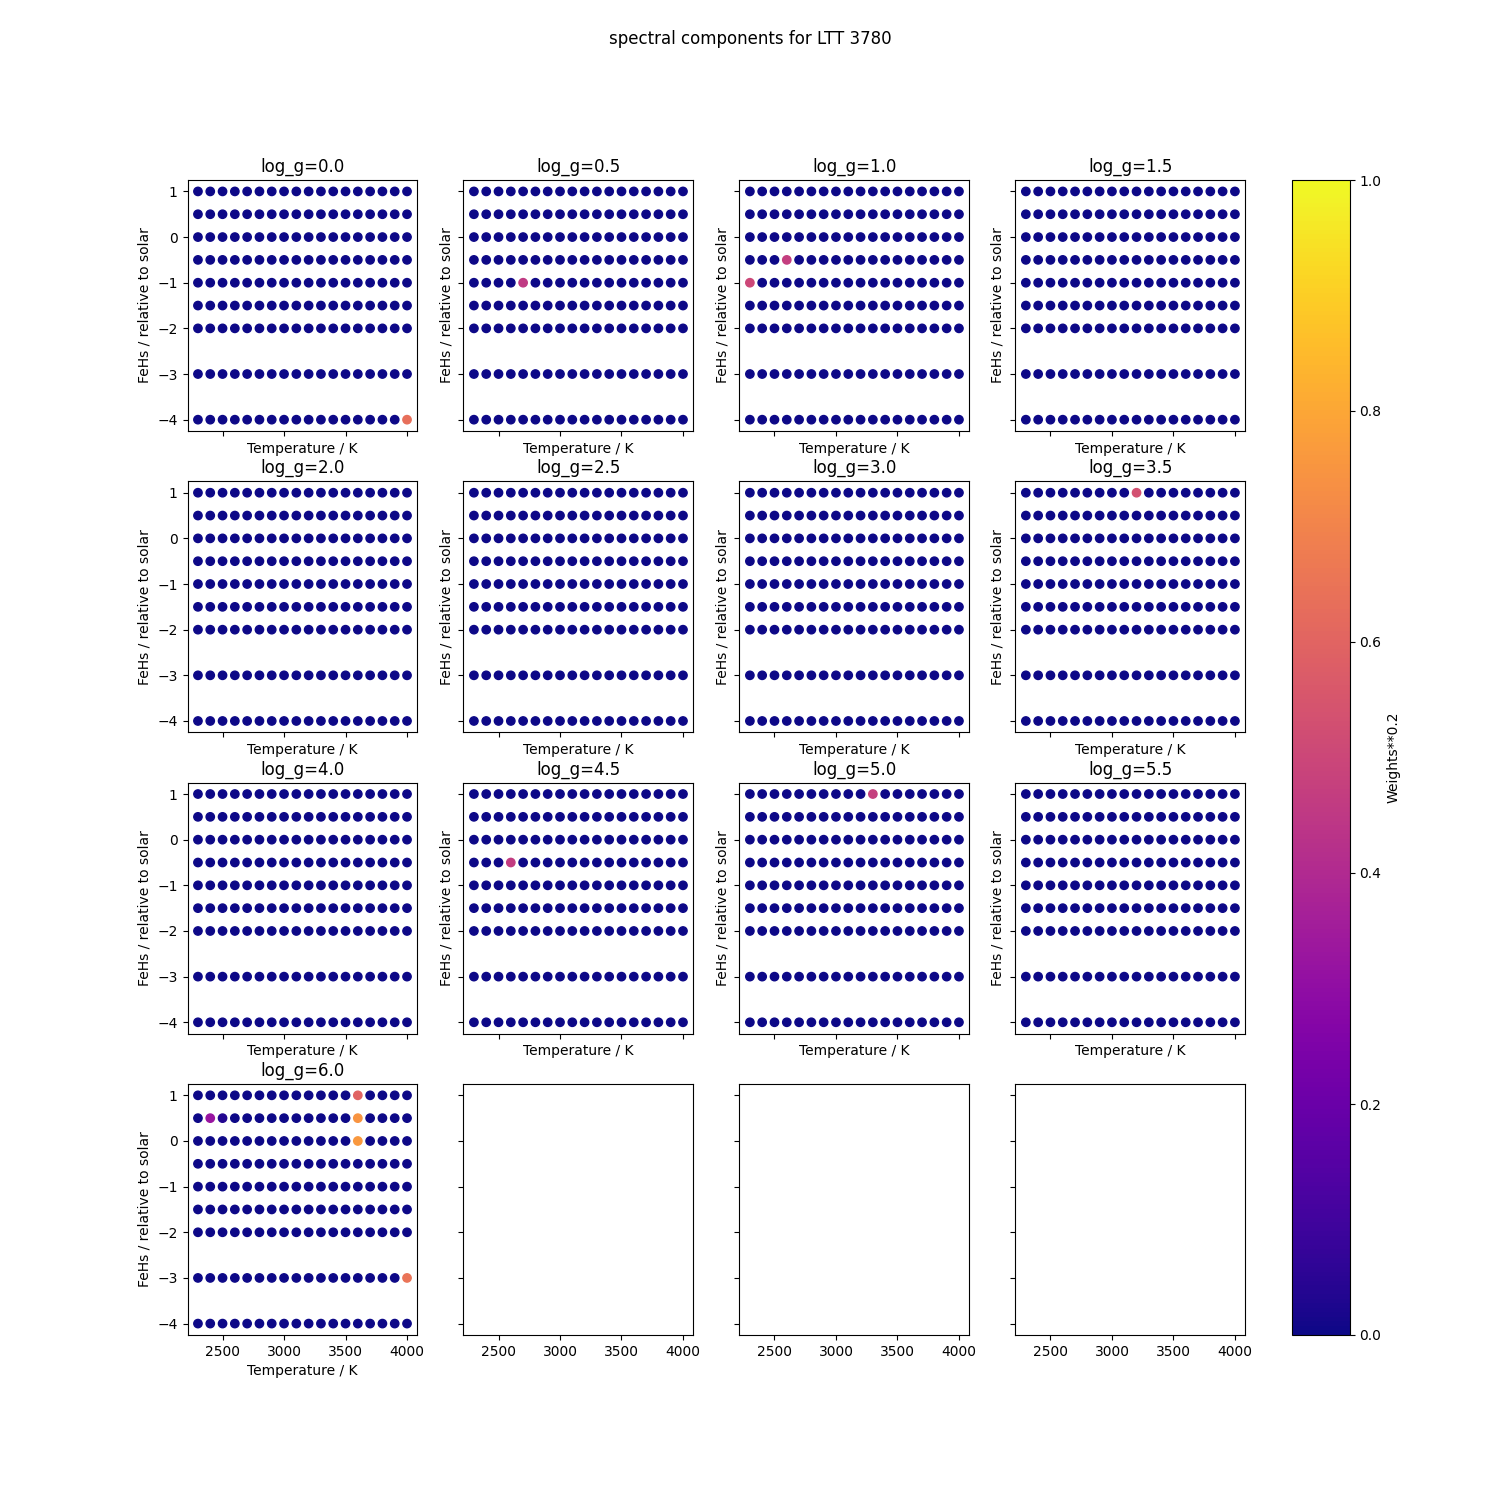

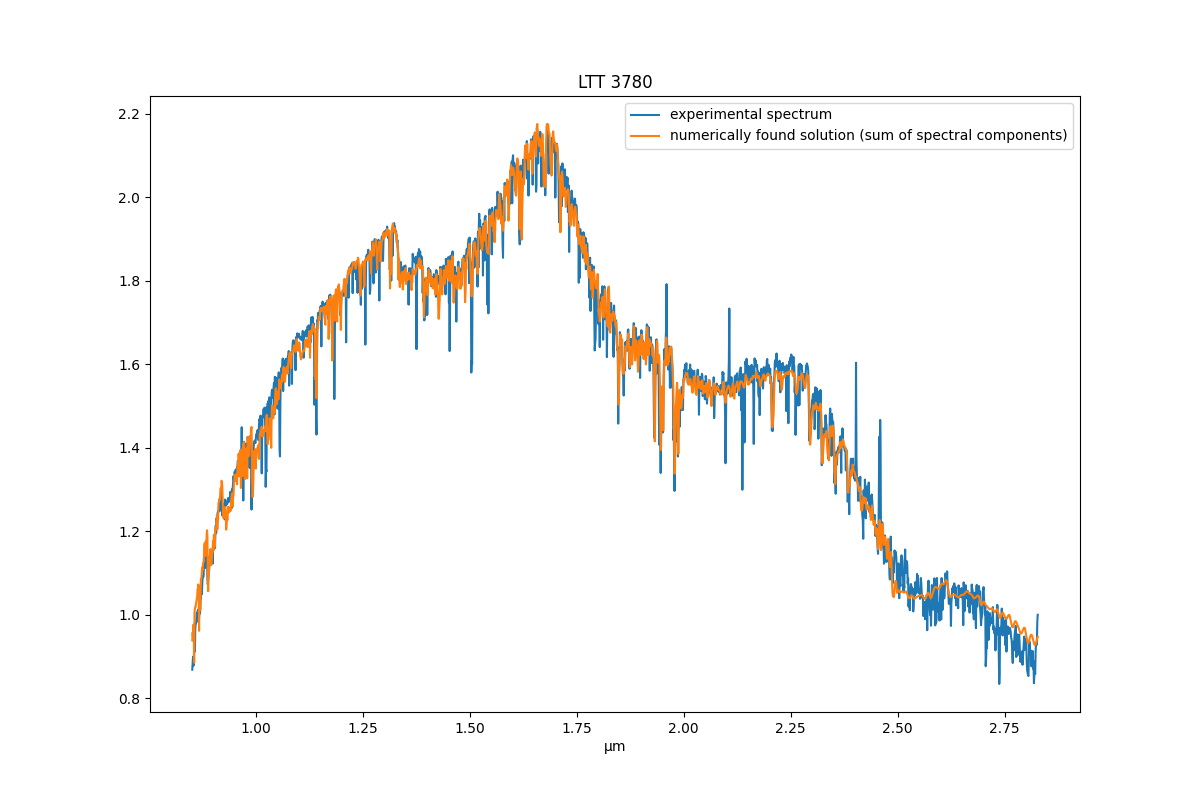

In [20]:

# # # plot some data # # #

result_map = {}
i = 0
for T_eff, FeH, log_g in product(T_effs, FeHs, log_gs):
    key = (T_eff, FeH, log_g)
    result_map[key] = i
    i += 1

    from phoenix_grid_creator.fits_to_hdf5 import TEFF_COLUMN, FEH_COLUMN, LOGG_COLUMN

WEIGHT_COLUMN : str = "weight"

hash_map = pd.DataFrame(columns=[TEFF_COLUMN, FEH_COLUMN, LOGG_COLUMN, WEIGHT_COLUMN])

for T_eff, FeH, log_g in product(T_effs, FeHs, log_gs):
    new_row = {TEFF_COLUMN: T_eff, FEH_COLUMN: FeH, LOGG_COLUMN: log_g, WEIGHT_COLUMN: result.x[result_map[(T_eff, FeH, log_g)]]}
    hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)

print(hash_map.sort_values(WEIGHT_COLUMN, ascending=False)[0:10])

fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
axes = axes.ravel()
for i, log_g in enumerate(log_gs):
    subset = hash_map[hash_map[LOGG_COLUMN] == log_g]
    x_vals = [a.value for a in subset[TEFF_COLUMN]]
    y_vals = subset[FEH_COLUMN]
    z_vals = subset[WEIGHT_COLUMN]

    sc = axes[i].scatter(x_vals, y_vals, c=z_vals**.2, cmap='plasma', vmin=0, vmax=1)

    axes[i].set_title(f"log_g={log_g}")
    axes[i].set_xlabel("Temperature / K")
    axes[i].set_ylabel("FeHs / relative to solar")
    # axes[i].set_xticks(np.arange(np.min(T_effs) / u.K, np.max(T_effs) / u.K + 1, 50) * u.K)
    # axes[i].grid()

cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label("Weights**0.2")
fig.suptitle("spectral components for LTT 3780")
plt.show()

plt.figure(figsize=(12,8))
plt.title("LTT 3780")
plt.plot(spectrum_to_decompose[WAVELENGTH_COLUMN], spectrum_to_decompose[FLUX_COLUMN], label="experimental spectrum")
plt.plot(spectrum_to_decompose[WAVELENGTH_COLUMN], A @ result.x, label="numerically found solution (sum of spectral components)")

plt.legend()
plt.show()